In [2]:
from platform import python_version
python_version()

'3.9.15'

## 1. Run imports

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

2023-01-30 12:04:20.447236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nitin/opt/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [344]:
import pdb

## 2. Pull + tokenize data

In [4]:
examples, metadata = tfds.load(
    'ted_hrlr_translate/pt_to_en',
    with_info=True,
    as_supervised=True
)

train_examples, val_examples = examples['train'], examples['validation']

2023-01-30 12:04:26.902275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
metadata

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_path='/Users/nitin/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0',
    file_format=tfrecord,
    download_size=124.94 MiB,
    dataset_size=10.89 MiB,
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('pt', 'en'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=1803, num_shards=1>,
        'train': <SplitInfo num_examples=51785, num_shards=1>,
        'validation': <SplitInfo num_examples=1193, num_shards=1>,


In [6]:
train_examples.batch?

In [7]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
        print('> Examples in Portugese:')
        for pt in pt_examples.numpy():
            print(pt.decode('utf-8'))
        print()
        
        print('> Examples in English:')
        for en in en_examples.numpy():
            print(en.decode('utf-8'))

> Examples in Portugese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2023-01-30 12:04:27.186824: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


**Tokenize the data!**

We are using a subword tokenizer (pieces of words), the [text.BertTokenizer](https://www.tensorflow.org/text/api_docs/python/text/BertTokenizer) that is optimized for this dataset.

Technically, this is a [Wordpiece Tokenizer](https://www.tensorflow.org/text/guide/bert_preprocessing_guide). I'll read this later

***

Input: Text data, variable length input

Output: Variable length token ID (integer) vectors, length = number of word pieces (determined by tokenizer) in input

In [8]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [9]:
tokenizers = tf.saved_model.load(model_name)

In [10]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [11]:
encoded = tokenizers.en.tokenize(en_examples)

In [12]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of English token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of English token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [13]:
# Converting back to see the tokenize + detokenize functions in action

round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [14]:
# Convert in more intricate lookup

tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The difference is you can see per token values, and you can see how some works are split up (eg search + ability)

In [15]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

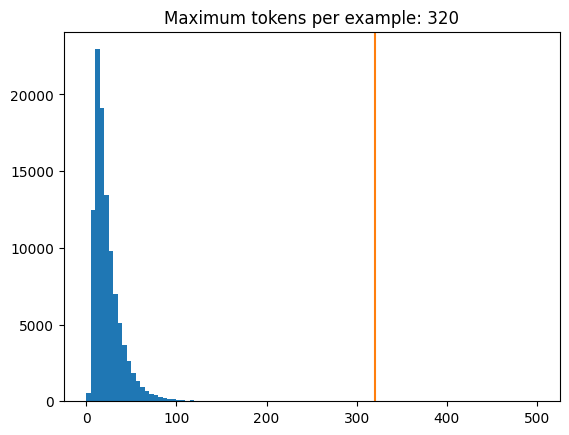

In [16]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

**We're going to convert to using a pipeline**

Take batches of text, convert them to a format suitable for training.

***

Inputs: Fixed length vectors of token IDs (this is after the `prepare_batch`), tying Portugese tokens to English tokens. Idk why we chop the `END` off of the `en_inputs` and the `START` off of the `labels` but hey, we do.

Outputs: A pipeline of shuffled `128` max length vectors of tokens in batches of `64`. Shuffled + cached. Dims `(128, 64)` (more accurately `(MAX_TOKENS, BATCH_SIZE)`, `128` and `64` are the initial values though).

In [17]:
MAX_TOKENS = 128

def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt[:, :MAX_TOKENS] # Trim to determined length
    pt = pt.to_tensor()
    
    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()
    en_labels = en[:, 1:].to_tensor()
    
    return (pt, en_inputs), en_labels

- `shuffle`: Randomize order
- `batch`: Tokenizer is more efficient on large batches. Not sure if generalizes
- `map`: Guessing tells it how to put the batch together
- `cache`: It says this method is called but I don't see it so just adding it lmfao

In [18]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [19]:
def make_batches(ds):
    return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .cache()
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

The functions we just defined will take the datasets that we built and turn them into readable timelines.

Actually run this function on the datasets.

In [109]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [110]:
for (pt, en), en_labels in train_batches.take(1):
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 105)
(64, 117)
(64, 117)


2023-02-06 09:44:46.392100: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## 3. Input Embedding

It looks like we don't do anything here because you eventually will just throw this `Embedding` into the `model` in `model.add`. So going to ignore for now.

In [22]:
tf.keras.layers.Embedding?

In [23]:
tf.keras.layers.Embedding(1000, 64, input_length=10)

## 4. Positional Encoding

Inputs: Embedded vector, dimensions: `(batch_size, input_length, embedding_dimension)`. 

For our cases: `(64, 128, embedding_dimension)`

A batch of `64` vectors, representing input data sentences/phrases...
Each of max `128` length...
Where each member was a word/word piece, now tokenized + embedded into an `embedding_dimension` length vector.

Output: `(64, 128, embedding_dimension)` --> The values here are different than the input matrix though. Instead, it'll be:

A batch of `64` vectors, representing input data sentences/phrases...
Each of max `128` length...
Where each member was a word/word piece, now based on the position of the word in the `128` length vector (`pos` in the equation below) has an `embeddings_dimension` length vector, where `d_model = embedding_dimension` and `i = the position in the vector`

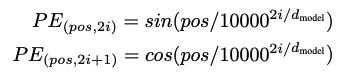

In [24]:
from IPython.display import Image

Image(filename='/Users/nitin/ml-projects/tf-attention-is-all-you-need/positional-encoding-equations.png', width=400)

In [25]:
import math

In [26]:
# np.sin(y / (10000 ** (z / np.float32(test_positional_matrix.shape[2]))))  \
# math.cos(y / (10000 ** (z / d_model)))

def test_fn(x, y, z):
    print(y)
    print(z.shape)
    return z

example_matrix_for_test = np.fromfunction(
    test_fn,
    (3, 3, 3)
)

example_matrix_for_test

[[[0. 0. 0.]
  [1. 1. 1.]
  [2. 2. 2.]]

 [[0. 0. 0.]
  [1. 1. 1.]
  [2. 2. 2.]]

 [[0. 0. 0.]
  [1. 1. 1.]
  [2. 2. 2.]]]
(3, 3, 3)


array([[[0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.]],

       [[0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.]],

       [[0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.]]])

In [27]:
np.sin?

In [28]:
np.repeat?

In [120]:
def positional_encoding(embedded_data):
    num_words = embedded_data.shape[1]
    d_model = int(embedded_data.shape[2] / 2)
    encoding_shape = (num_words, d_model * 2)
    
    angle_constants = np.full(encoding_shape, 10000)
    
    angle_exponents = np.tile(
        np.repeat(np.arange(d_model), 2),
        (num_words, 1)
    )
    angle_exponents = np.divide(angle_exponents, d_model)
    
    angle_numerators = np.tile(
        np.arange(num_words),
        (d_model * 2, 1)
    )
    
    angles = np.divide(angle_numerators.T, np.power(angle_constants, angle_exponents))
    
    sine_where_vals = np.tile(
        np.array([i % 2 == 0 for i in range(embedded_data.shape[2])]),
        (embedded_data.shape[1], 1)
    )    
    np.sin(angles, out=angles, where=sine_where_vals)
    cosine_where_vals = np.tile(
        np.array([i % 2 == 1 for i in range(embedded_data.shape[2])]),
        (embedded_data.shape[1], 1)
    )
    np.cos(angles, out=angles, where=cosine_where_vals)
    
    return tf.cast(angles, dtype=tf.float32)

Things my implementation doesn't seem to do as well:

Most other ones online seem to be using `np.sin` + `np.cosin` on a vector... maybe that's more efficient, `np.fromfunction` likely does it per item and doesn't optimize the sine + cosine functions.

In [30]:
test_positional_matrix = np.random.randn(12, 2048, 512)
bloop = positional_encoding(test_positional_matrix)
bloop.shape

TensorShape([2048, 512])

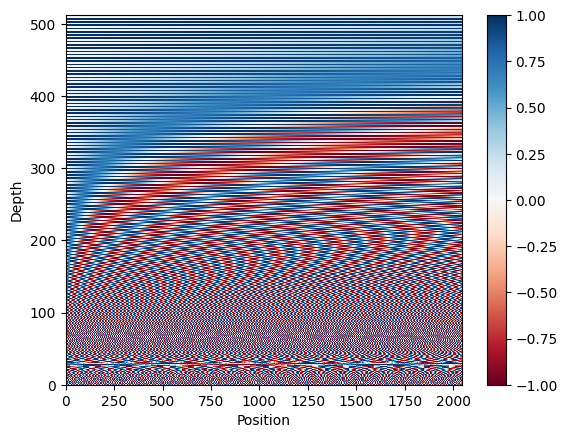

In [31]:
# Plot the dimensions.
plt.pcolormesh(bloop.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Sines

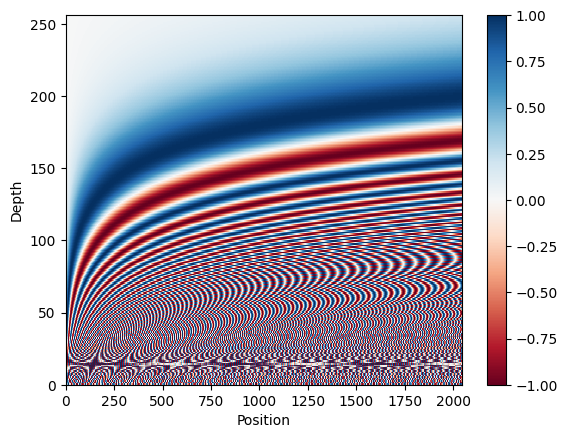

In [32]:
# Plot the dimensions.
plt.pcolormesh(bloop.numpy().T[::2], cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Cosines

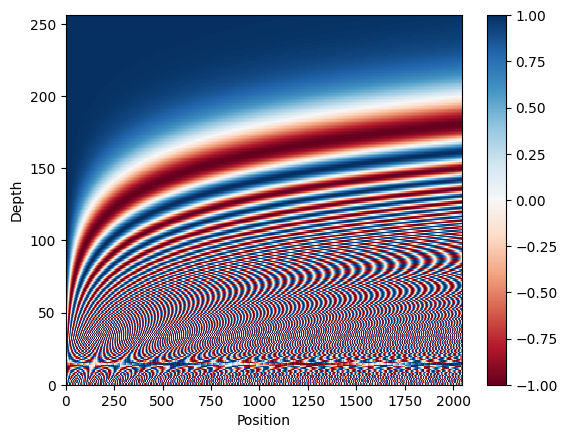

In [33]:
# Plot the dimensions.
plt.pcolormesh(bloop.numpy().T[1::2], cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

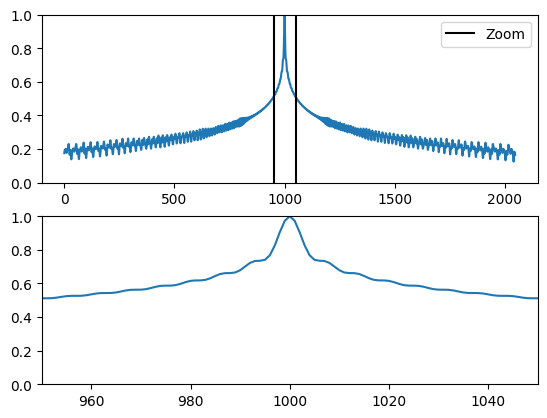

In [34]:
bloop/=tf.norm(bloop, axis=1, keepdims=True)
p = bloop[1000]
dots = tf.einsum('pd,d -> p', bloop, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [35]:
def positional_encoding_from_tf_tutorial(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)
    
    print(angle_rads.shape)
    
    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)


In [36]:
bloop[0] == positional_encoding_from_tf_tutorial(2048, 512)

(2048, 256)


<tf.Tensor: shape=(2048, 512), dtype=bool, numpy=
array([[ True, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])>

**Putting the embedding + encoding together**

Doing this in a class because I snuck a peek at the official tutorial. Okay, I jacked the whole thing from the tutorial.

In [37]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(np.zeros((1, vocab_size, d_model)))
    
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :] 
        return x

In [38]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [39]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 120), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

## 5. Multi-Head Attention Layer

This is going to be a fun one. We're gong to have to build out:

1. Scaled Dot-Product Attention - given a query, key, and value vector, process an output attention value
2. Single-Head Attention - Supplement the query, key, and value vectors with linear layers that can be trained. Put a linear layer after the attention output to be trained as well.
3. Multi-Head Attention - Run SHA multiple times to avoid being foucsed in specific feature spaces.

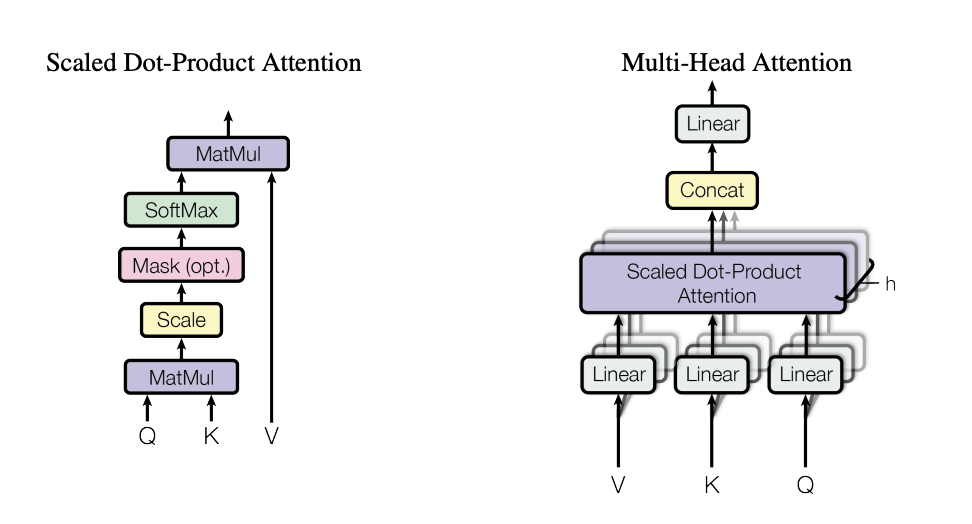

In [40]:
Image(filename='/Users/nitin/ml-projects/tf-attention-is-all-you-need/attention-calculation.png', width=600)

In [350]:
# Create a tensor with the sequence lengths

def generate_mask_tensor(sample_size):
    pdb.set_trace()
    sequence_lengths = tf.constant(
        tf.range(sample_size, 0, -1),
        dtype=tf.int32
    )

    # Create a tensor with the maximum length of the sequences
    max_sequence_length = tf.reduce_max(sequence_lengths)

    # Create a tensor with the mask indices
    mask_indices = tf.range(max_sequence_length)
    mask_indices = tf.expand_dims(mask_indices, 0)
    mask_indices = tf.tile(mask_indices, [tf.shape(sequence_lengths)[0], 1])

    # Create a boolean mask based on the sequence lengths
    sequence_mask = tf.less(mask_indices, tf.expand_dims(sequence_lengths, 1))

    # Convert the boolean mask to a float tensor
    mask = tf.where(sequence_mask, tf.ones_like(mask_indices, dtype=tf.float32),
                    -1e9 * tf.ones_like(mask_indices, dtype=tf.float32))

    return mask

In [352]:
generate_mask_tensor(tf.constant(10))

> /var/folders/pm/k0dlv40n5h56f48sgj8kkh900000gn/T/ipykernel_98379/108270022.py(5)generate_mask_tensor()
      3 def generate_mask_tensor(sample_size):
      4     pdb.set_trace()
----> 5     sequence_lengths = tf.constant(
      6         tf.range(sample_size, 0, -1),
      7         dtype=tf.int32

ipdb> sample_size
<tf.Tensor: shape=(), dtype=int32, numpy=10>
ipdb> n
> /var/folders/pm/k0dlv40n5h56f48sgj8kkh900000gn/T/ipykernel_98379/108270022.py(6)generate_mask_tensor()
      4     pdb.set_trace()
      5     sequence_lengths = tf.constant(
----> 6         tf.range(sample_size, 0, -1),
      7         dtype=tf.int32
      8     )

ipdb> n
> /var/folders/pm/k0dlv40n5h56f48sgj8kkh900000gn/T/ipykernel_98379/108270022.py(7)generate_mask_tensor()
      5     sequence_lengths = tf.constant(
      6         tf.range(sample_size, 0, -1),
----> 7         dtype=tf.int32
      8     )
      9 

ipdb> n
> /var/folders/pm/k0dlv40n5h56f48sgj8kkh900000gn/T/ipykernel_98379/108270022.py(5)generate_m

In [335]:
tf.range?

In [336]:
test_mask_tensor = generate_mask_tensor(10)
print(test_mask_tensor.shape)
list_of_test_mask_tensors = [test_mask_tensor for _ in range(6)]
test_stacked_mask_tensor = tf.stack(list_of_test_mask_tensors)
print(test_stacked_mask_tensor.shape)

(10, 10)
(6, 10, 10)


In [255]:
math.sqrt(tf.shape(test_stacked_mask_tensor)[0])

2.449489742783178

In [337]:
"""
Scaled Dot-Product Attention

The meat of the paper, how do we identify the most important and relevant regions
of an input. Where likely similarities reside. This can be used for self-attention,
to identify the most sticking-out parts of our input. This can be used when comparing the
model's input and output, to see what parts of the input likely line up with the output.

"""
class ScaledDotProductAttentionLayer(tf.keras.layers.Layer):

    def call(self, Q, K, V, mask=False):
        """
        @param query: Query, the input that we're looking to inspect for similarities, Dims: (m, d_k)
        @param key: Key, the input to output transforming vector that we're looking at, Dims: (m, d_k)
        @param value: Value, the final output vector that is being transformed, Dims: (m, d_v)

        Where m is the number of words in a data point.

        @return: Attention vector Z!
        """
        
        num_samples = tf.shape(Q)[-2]
        d_k = tf.shape(Q)[-1]
        
        Z = tf.matmul(Q, K, transpose_b=True)
        # After this, Z has dims (m, m)
        # If a batched dataset, dims are (batch_size, m, m)
        
        Z = Z / tf.sqrt(tf.cast(d_k, dtype=tf.keras.backend.floatx()))
        if mask:
            blank_mask_tensor = generate_mask_tensor(
                tf.cast(num_samples, dtype=tf.int32)
            )
            Z = tf.multiply(Z, blank_mask_tensor)
#             for sample_index in range(num_samples):
#                 Z[:, sample_index, sample_index+1:] = 1.
#                 Z[:, sample_index, :sample_index] = 0.

        Z = tf.nn.softmax(Z)
        
        Z = tf.matmul(Z, V)
        return Z

In [210]:
"""
Single-Head Attention Layer

Let's goooo

"""
class SingleHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, use_output_linear=True):
        super().__init__()
        self.q_linear = tf.keras.layers.Dense(d_model)
        self.k_linear = tf.keras.layers.Dense(d_model)
        self.v_linear = tf.keras.layers.Dense(d_model)
        self.sdpa_layer = ScaledDotProductAttentionLayer()
        self.use_output_linear = use_output_linear
        self.output_linear = tf.keras.layers.Dense(d_model)

    def call(self, Q, K, V, mask=False):
        """
        @param query: Query, the input that we're looking to inspect for similarities, Dims: (m, d_k)
        @param key: Key, the input to output transforming vector that we're looking at, Dims: (m, d_k)
        @param value: Value, the final output vector that is being transofrmed, Dims: (m, d_v)

        Where m is the number of words in a data point.

        @return: Attention vector Z!
        """

        Q = self.q_linear(Q)
        K = self.k_linear(K)
        V = self.v_linear(V)
        Z = self.sdpa_layer(Q, K, V, mask)
        
        if self.use_output_linear:
            Z = self.output_linear(Z)
        
        return Z

In [63]:
"""
Multi-Head Attention Layer

I know I put that I'd do Single Attention first, but I think because of the Concat layer,
it's better to just throw it in one.
"""
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads=1, dropout_rate=0.1):
        super().__init__()
        self.attention_layers = [SingleHeadAttentionLayer(d_model, False) for i in range(num_heads)]
        self.concatenate = tf.keras.layers.Concatenate(axis=-1)
        self.output_linear = tf.keras.layers.Dense(d_model)
        # Add and Norm
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()
    
    def call(self, Q, K, V, mask=False):
        Z_list = [attention_layer(Q, K, V, mask) for attention_layer in self.attention_layers]
        Z = self.concatenate(Z_list)
        Z = self.output_linear(Z)
        
        Z = self.add([Z, self.seq(Z)])
        Z = self.layer_norm(Z)
        
        return Z

## 6. Feed Forwards Layer

In [64]:
class FeedForwardLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [65]:
sample_ffn = FeedForwardLayer(512, 2048)

In [66]:
print(pt_emb.shape)
print(sample_ffn(pt_emb).shape)

(64, 127, 512)
(64, 127, 512)


## 7. Encoder Layer

Open points of work left:
- More dyanmic setting of linear layer units
- Testing and comparing this encoder layer

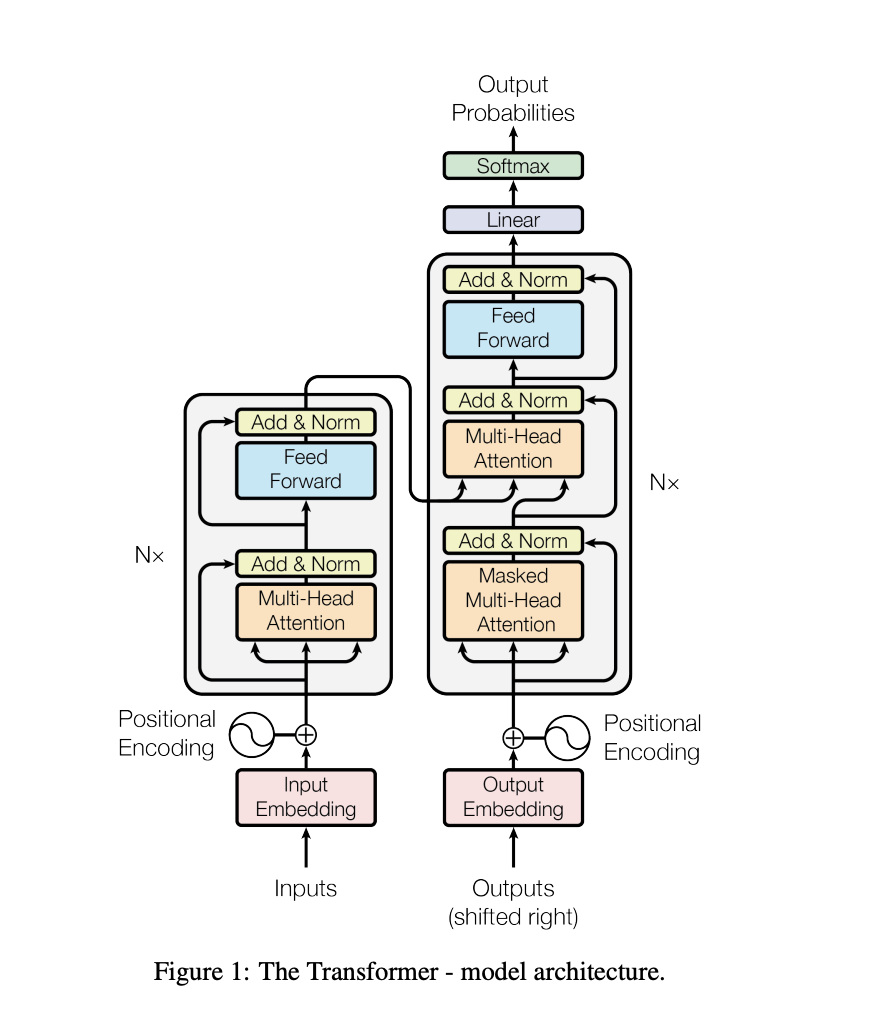

In [67]:
Image(filename='/Users/nitin/ml-projects/tf-attention-is-all-you-need/full-architecture.png', width=400)

In [68]:
tf.keras.layers.Dense?

In [69]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, dff, d_model, num_heads, dropout_rate=0.1):
        super().__init__()
        self.mha_layer = MultiHeadAttentionLayer(d_model, dff, num_heads)
        self.feed_forward = FeedForwardLayer(d_model, dff)
    
    def call(self, X):
        X_w_attention = self.mha_layer(X, X, X, mask=False)
        X_feed_forward = self.feed_forward(X_w_attention)
        return X_feed_forward

In [70]:
encoder_layer = EncoderLayer(2048, 512, 8)

print(pt_emb.shape)
print(encoder_layer(pt_emb).shape)

(64, 127, 512)
(64, 127, 512)


In [71]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, dff, num_heads, num_layers, dropout_rate=0.1):
        super().__init__()
        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.encoder_layers = [EncoderLayer(dff, d_model, num_heads, dropout_rate) for i in range(num_layers)]

    def call(self, X):
        X = self.positional_embedding(X)
        for layer in self.encoder_layers:
            X = layer(X)
        return X

In [72]:
encoder = Encoder(8500, 512, 2048, 8, 4)

print(en.shape)
print(encoder(en).shape)
print(pt.shape)
print(encoder(pt).shape)

(64, 120)
(64, 120, 512)
(64, 127)
(64, 127, 512)


## 8. Decoder Layer

In [88]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, dff, d_model, num_heads, dropout_rate=0.1):
        super().__init__()
        self.masked_mha_layer = MultiHeadAttentionLayer(d_model, dff, num_heads)
        self.combined_mha_layer = MultiHeadAttentionLayer(d_model, dff, num_heads)
        self.feed_forward = FeedForwardLayer(d_model, dff)
    
    def call(self, X, context):
        X_self_attention = self.masked_mha_layer(X, X, X, mask=True)
        X_all_attention = self.combined_mha_layer(X, context, context, mask=False)
        X_feed_forward = self.feed_forward(X_all_attention)
        
        return X_feed_forward

## 9. Decoder

In [89]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, dff, num_heads, num_layers, dropout_rate=0.1):
        super().__init__()
        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(dff, d_model, num_heads, dropout_rate) for i in range(num_layers)]
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff),
            tf.keras.layers.Dropout(dropout_rate)
        ])

    def call(self, X, context):
        X = self.positional_embedding(X)
        for layer in self.decoder_layers:
            X = layer(X, context)
        X = self.seq(X)
        X = tf.nn.softmax(X)
        return X

In [93]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    X=en,
    context=pt_emb)

# Print the shapes.

print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 120)
(64, 127, 512)
(64, 120, 2048)


#### Connect the dots, full `Transformer`

From here on out I jack way more heavily from the tutorial because I want this done lmfao

In [319]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inputs):
        # Inputs must be packed into one argument
        print(inputs)
        context, X = inputs
        
        context = self.encoder(context)
        
        X = self.decoder(X, context)
        
        logits = self.final_layer(X)
        
        try:
            del logits._keras_mask
        except AttributeError:
            pass
    
        return logits


#### Hyperparameters

In [320]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [338]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [339]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(<tf.Tensor: shape=(64, 105), dtype=int64, numpy=
array([[   2,  260, 1449, ...,    0,    0,    0],
       [   2,   40, 2721, ...,    0,    0,    0],
       [   2,   85,  187, ...,    0,    0,    0],
       ...,
       [   2,  114,   44, ...,    0,    0,    0],
       [   2,  127,   55, ...,    0,    0,    0],
       [   2, 1104,   91, ...,    0,    0,    0]])>, <tf.Tensor: shape=(64, 117), dtype=int64, numpy=
array([[   2,   77,   81, ...,    0,    0,    0],
       [   2,  990,  136, ...,    0,    0,    0],
       [   2,   72,  103, ...,    0,    0,    0],
       ...,
       [   2,  192,  196, ...,    0,    0,    0],
       [   2,  115, 4034, ...,    0,    0,    0],
       [   2,  421,  494, ...,    0,    0,    0]])>)
(64, 117)
(64, 105)
(64, 117, 7010)


In [330]:
transformer.summary()

Model: "transformer_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_29 (Encoder)        multiple                  4159616   
                                                                 
 decoder_40 (Decoder)        multiple                  6766848   
                                                                 
 dense_16580 (Dense)         multiple                  3596130   
                                                                 
Total params: 14,522,594
Trainable params: 14,522,594
Non-trainable params: 0
_________________________________________________________________


### Training

Uses a custom schedule for an Adam optimizer

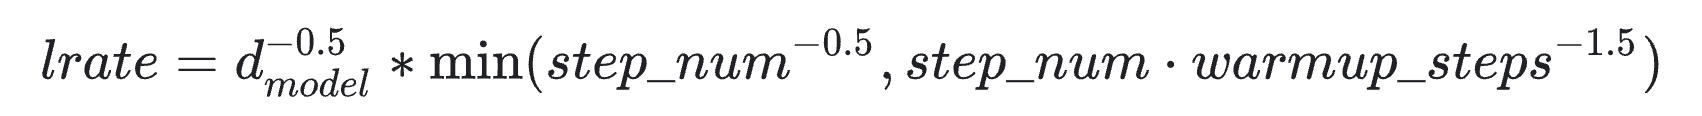

In [100]:
Image(filename='/Users/nitin/ml-projects/tf-attention-is-all-you-need/custom-optimizer.png', width=800)

Jacked from tutorial lmfaooo

In [101]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [102]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

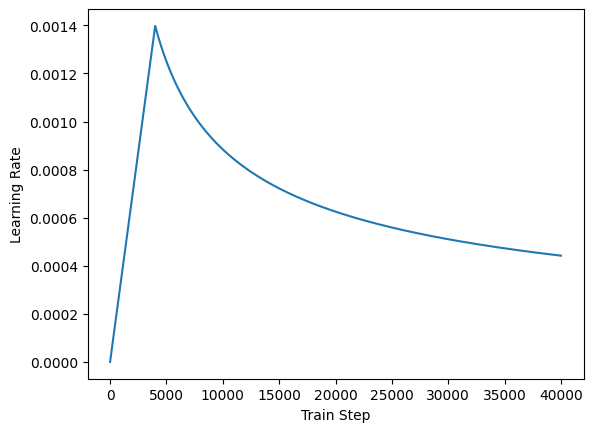

In [103]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Loss

So this isn't actually specified in the paper. We know that it's going to be a categorical logit loss. Idk beyond that...

> Cross entropy loss function is an optimization function which is used in case of training a classification model which classifies the data by predicting the probability of whether the data belongs to one class or the other class. One of the examples where Cross entropy loss function is used is Logistic Regression.

There we go! Lowkey saw cross entropy in the tutorial so I got tipped off but I've seen it before I promise

In [104]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)


### Running training

In [342]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [353]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
(<tf.Tensor 'IteratorGetNext:0' shape=(None, None) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None) dtype=int64>)
> /var/folders/pm/k0dlv40n5h56f48sgj8kkh900000gn/T/__autograph_generated_filevkc3usam.py(11)tf__generate_mask_tensor()
      9                 retval_ = ag__.UndefinedReturnValue()
     10                 ag__.ld(pdb).set_trace()
---> 11                 sequence_lengths = ag__.converted_call(ag__.ld(tf).constant, (ag__.converted_call(ag__.ld(tf).range, (ag__.ld(sample_size), 0, -1), None, fscope),), dict(dtype=ag__.ld(tf).int32), fscope)
     12                 max_sequence_length = ag__.converted_call(ag__.ld(tf).reduce_max, (ag__.ld(sequence_lengths),), None, fscope)
     13                 mask_indices = ag__.converted_call(ag__.ld(tf).range, (ag__.ld(max_sequence_length),), None, fscope)

ipdb> sample_size
<tf.Tensor 'transformer_29/decoder_41/decoder_layer_164/multi_head_attention_layer_459/single_head_attention_layer_3672/scaled_dot_product_a

ipdb> n
> /Users/nitin/opt/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py(443)converted_call()
    441         result = converted_f(*effective_args)
    442     except Exception as e:
--> 443       _attach_error_metadata(e, converted_f)
    444       raise
    445 

ipdb> n
> /Users/nitin/opt/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py(444)converted_call()
    442     except Exception as e:
    443       _attach_error_metadata(e, converted_f)
--> 444       raise
    445 
    446   return result

ipdb> n
> /Users/nitin/opt/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py(444)converted_call()
    442     except Exception as e:
    443       _attach_error_metadata(e, converted_f)
--> 444       raise
    445 
    446   return result

ipdb> n
> /Users/nitin/opt/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py(444)converted_call()
    442 